# Virus-Host Species Relation Extraction
## Notebook 4: Discriminative Model and Evaluation
### UC Davis Epicenter for Disease Dynamics

- End extraction task using grid search over Sparse Logistic Regression models
- Evaluation with scoring metrics, ROC Curve, Precision-Recall Curve

In [188]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import re
import numpy as np
from snorkel import SnorkelSession
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Connect to the database backend and initalize a Snorkel session
session = SnorkelSession()


#from lib.init import *
from snorkel.models import candidate_subclass
from snorkel.annotations import load_gold_labels

from snorkel.lf_helpers import (
    get_left_tokens, get_right_tokens, get_between_tokens,
    get_text_between, get_tagged_text,
)

VirusHost = candidate_subclass('VirusHost', ['virus', 'host'])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [189]:
from snorkel.annotations import load_marginals

train_cands = session.query(VirusHost).filter(VirusHost.split == 0).order_by(VirusHost.id).all()
dev_cands   = session.query(VirusHost).filter(VirusHost.split == 1).order_by(VirusHost.id).all()
test_cands  = session.query(VirusHost).filter(VirusHost.split == 2).order_by(VirusHost.id).all()

L_gold_dev  = load_gold_labels(session, annotator_name='gold', split=1, load_as_array=True)

In [190]:
from util_virushost import load_external_labels

missed = load_external_labels(session, VirusHost, annotator_name = 'gold', split = 2)

L_gold_test = load_gold_labels(session, annotator_name = 'gold', split = 2)

L_gold_test

AnnotatorLabels created: 0


<357x1 sparse matrix of type '<class 'numpy.int32'>'
	with 38 stored elements in Compressed Sparse Row format>

### Feature Extraction
Instead of using a deep learning approach to start, let's look at a standard sparse logistic regression model. First, we need to extract out features. This can take a while, but we only have to do it once!

In [191]:
from features import hybrid_span_mention_ftrs
from snorkel.annotations import FeatureAnnotator

featurizer = FeatureAnnotator(f=hybrid_span_mention_ftrs)

In [192]:

F_train = featurizer.load_matrix(session, split=0)
F_dev   = featurizer.load_matrix(session, split=1)
F_test  = featurizer.load_matrix(session, split=2)

if F_train.size == 0:    
    %time F_train = featurizer.apply(split=0, parallelism=1)
if F_dev.size == 0:     
    %time F_dev  = featurizer.apply_existing(split=1, parallelism=1)
if F_test.size == 0:
    %time F_test = featurizer.apply_existing(split=2, parallelism=1)

print(F_train.shape)
print(F_dev.shape)
print(F_test.shape)

(3795, 53418)
(150, 53418)
(357, 53418)


In [193]:
# reload marginals
train_marginals = load_marginals(session, split=0)

### Logistic Regression Grid Search for Tuning Hyperparameters

In [194]:
from snorkel.learning import RandomSearch
from snorkel.learning.tensorflow import SparseLogisticRegression

seed = 1234
num_model_search = 5

# search over this parameter grid
param_grid = {}
param_grid['batch_size'] = [64, 128]
param_grid['lr']         = [1e-4, 1e-3, 1e-2]
param_grid['l1_penalty'] = [1e-6, 1e-4, 1e-2]
param_grid['l2_penalty'] = [1e-6, 1e-4, 1e-2]
param_grid['rebalance']  = [0.0, 0.5]

model_class_params = {
    'n_threads':1
}

model_hyperparams = {
    'n_epochs': 30,
    'print_freq': 10,
    'dev_ckpt_delay': 0.5,
    'X_dev': F_dev,
    'Y_dev': L_gold_dev
}

searcher = RandomSearch(SparseLogisticRegression, param_grid, F_train, train_marginals,
                        n=num_model_search, seed=seed,
                        model_class_params=model_class_params,
                        model_hyperparams=model_hyperparams)

print("Discriminitive Model Parameter Space (seed={}):".format(seed))
for i, params in enumerate(searcher.search_space()):
    print("{} {}".format(i, params))

disc_model, run_stats = searcher.fit(X_valid = F_dev, Y_valid = L_gold_dev, n_threads = 1)
run_stats

Discriminitive Model Parameter Space (seed=1234):
0 (128, 0.0001, 0.01, 0.01, 0.0)
1 (128, 0.0001, 0.01, 0.01, 0.5)
2 (64, 0.001, 0.01, 0.01, 0.0)
3 (128, 0.001, 1e-06, 1e-06, 0.5)
4 (64, 0.001, 1e-06, 1e-06, 0.5)
[1] Testing batch_size = 64, lr = 1.00e-04, l1_penalty = 1.00e-06, l2_penalty = 1.00e-04, rebalance = 0.00e+00
[SparseLogisticRegression] Training model
[SparseLogisticRegression] n_train=3795  #epochs=30  batch size=64
[SparseLogisticRegression] Epoch 0 (2.75s)	Average loss=0.809929	Dev F1=69.81
[SparseLogisticRegression] Epoch 10 (27.81s)	Average loss=0.445980	Dev F1=72.48
[SparseLogisticRegression] Epoch 20 (53.77s)	Average loss=0.401933	Dev F1=74.21
[SparseLogisticRegression] Model saved as <SparseLogisticRegression>
[SparseLogisticRegression] Epoch 29 (77.26s)	Average loss=0.382081	Dev F1=75.34
[SparseLogisticRegression] Model saved as <SparseLogisticRegression>
[SparseLogisticRegression] Training done (77.60s)
INFO:tensorflow:Restoring parameters from checkpoints\Sparse

,batch_size,lr,l1_penalty,l2_penalty,rebalance,Prec.,Rec.,F-1
4,64,0.0100,0.000001,0.000001,0.5,0.755245,0.964286,0.847059
1,64,0.0010,0.000100,0.010000,0.5,0.741259,0.946429,0.831373
3,64,0.0100,0.010000,0.010000,0.0,0.741007,0.919643,0.820717
2,128,0.0100,0.000001,0.000100,0.0,0.769912,0.776786,0.773333
0,64,0.0001,0.000001,0.000100,0.0,0.756757,0.750000,0.753363


### Running just the best model (using parameters found from the grid search)

In [195]:
print('Prec, Recall, F1 scores for Dev and Test Sets')
print(np.round(disc_model.score(F_dev, L_gold_dev, set_unlabeled_as_neg=False), 3)) # dev set
print(np.round((disc_model.score(F_test, L_gold_test, set_unlabeled_as_neg=False)), 3)) # test set

Prec, Recall, F1 scores for Dev and Test Sets
[0.947 0.964 0.956]
[0.973 0.973 0.973]


In [196]:
# Extracting features allows us to inspect and interperet our learned weights
from scoring import *
print_top_k_features(session, disc_model, F_train, top_k=10)

53418
[-1.0058558, 'WIN_LEFT_SEQ_LEMMAS[, tyuleniy]']
[-0.97780144, 'WIN_LEFT_SEQ_LEMMAS[) , tyuleniy]']
[-0.9692028, 'WIN_LEFT_LEMMAS[tyuleniy]']
[-0.69104046, 'BETWEEN_LEMMAS[not]']
[-0.68393975, 'WIN_RIGHT_SEQ_LEMMAS[human case oc-]']
[-0.68248415, 'WIN_RIGHT_SEQ_POS_TAGS[JJ NN XX]']
[-0.68245965, 'WIN_RIGHT_SEQ_LEMMAS[human case]']
[-0.61547416, 'WIN_RIGHT_SEQ_LEMMAS[1 neg ne]']
[-0.59624314, 'WIN_RIGHT_SEQ_POS_TAGS[-RRB- NNP NNP]']
[-0.59273386, 'WIN_RIGHT_SEQ_LEMMAS[) flaviviridae]']
[-0.59175, 'WIN_RIGHT_SEQ_LEMMAS[) flaviviridae area]']
[-0.5907628, 'WIN_RIGHT_SEQ_POS_TAGS[NNP -RRB- NNP]']
[-0.58994806, 'WIN_RIGHT_SEQ_LEMMAS[denv ) flaviviridae]']
[-0.58762085, 'WIN_RIGHT_SEQ_LEMMAS[( denv )]']
[-0.5834352, 'WIN_RIGHT_SEQ_LEMMAS[denv )]']
[-0.56305647, 'WIN_RIGHT_SEQ_LEMMAS[( denv]']
[-0.55599296, 'WIN_RIGHT_LEMMAS[denv]']
[-0.514714, 'WIN_RIGHT_SEQ_LEMMAS[and solat]']
[-0.4946739, 'WIN_LEFT_LEMMAS[enzootic]']
[-0.47717974, 'WIN_RIGHT_SEQ_LEMMAS[1 neg]']
[-0.45070857, 'BETWEEN_

In [197]:
# performance on the test set
p, r, f1 = disc_model.score(X_test = F_test, Y_test = L_gold_test, set_unlabeled_as_neg=False)
print("Prec: {0:.3f}, Recall: {1:.3f}, F1 Score: {2:.3f}".format(p, r, f1))

Prec: 0.973, Recall: 0.973, F1 Score: 0.973


In [198]:
tp, fp, tn, fn = disc_model.error_analysis(session, 
                                           F_test, 
                                           L_gold_test,
                                           set_unlabeled_as_neg = False
                                          )

Scores (Un-adjusted)
Pos. class accuracy: 0.973
Neg. class accuracy: 0.0
Precision            0.973
Recall               0.973
F1                   0.973
----------------------------------------
TP: 36 | FP: 1 | TN: 0 | FN: 1



In [199]:
# save marginals (raw predictions on candidates)
test_marginals = disc_model.marginals(X = F_test)

### ROC Curve, Precision Recall Curve

In [200]:
# plot roc curves and prc curve

from sklearn.metrics import roc_curve, auc, precision_recall_curve, precision_score, recall_score
from matplotlib import pyplot as plt
%matplotlib inline 

In [201]:
gold_nums = []

for i in L_gold_test:
    new_i = i.todense()
    gold_nums.append(new_i[0,0])

y = np.asarray(gold_nums)

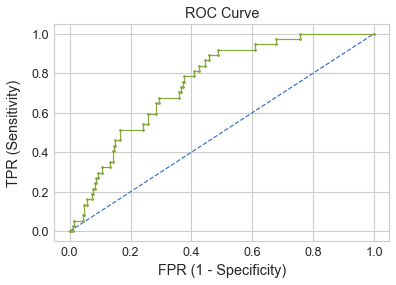

In [202]:
# ROC Curve Plot

# calculate roc curve
fpr, tpr, thresholds = roc_curve(y, test_marginals, pos_label=1)

# plot no skill line
plt.plot([0, 1], [0, 1], linestyle='--')

# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')

# show the plot
plt.title("ROC Curve")
plt.xlabel("FPR (1 - Specificity)", labelpad=5)
plt.ylabel("TPR (Sensitivity)", labelpad=10)
plt.savefig("roc_curve.png")
plt.show()

In [203]:
y_df = pd.DataFrame(y)
probs_df = pd.DataFrame(test_marginals)
new_df = pd.concat([y_df, probs_df], axis=1)
new_df.columns = 0,1
new_df = new_df[new_df[0] != 0]
new_y = new_df[0].to_numpy()
new_test_marginals = new_df[1].to_numpy()

In [204]:
# PRC Plot

# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(new_y, new_test_marginals, pos_label=1)

# calculate F1 score
#f1 = f1_score(new_y, new_test_marginals)

# calculate precision-recall AUC
auc = auc(recall, precision)

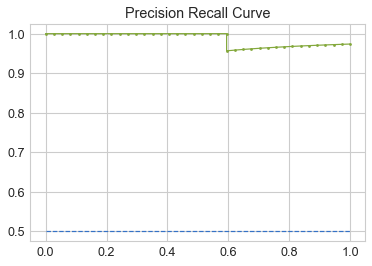

In [209]:
# plot no skill
plt.plot([0, 1], [0.5, 0.5], linestyle='--')

# plot the precision-recall curve for the model
plt.plot(recall, precision, marker='.')

# show the plot
plt.title("Precision Recall Curve")
plt.savefig("prc.png")
plt.show()

In [206]:
# view false positives
from snorkel.viewer import SentenceNgramViewer

SentenceNgramViewer(fp, session, height = 350)

<IPython.core.display.Javascript object>

SentenceNgramViewer(cids=[[[0]]], html='<head>\n<style>\nspan.candidate {\n    background-color: rgba(255,255,…

In [207]:
# export all candidates to csv file
df = pd.DataFrame({'id': [], 'virus': [], 'host': []}) # initialize df w three columns

# list all candidates (to export later and merge w predicted probabilities table?)
for c in session.query(VirusHost).all():
    df = df.append({'id': c.id, 'virus': c.virus.get_attrib_tokens("words"), 'host': c.host.get_attrib_tokens("words")}, ignore_index=True)
    
df2 = df[:] # make a copy of the df
df2['virus'] = df['virus'].str.join(' ')
df2['host'] = df['host'].str.join(' ')
df2['virus'] = df2['virus'].str.replace('[^a-zA-Z ]', '') # remove non alphaetic characters
df2['host'] = df2['host'].str.replace('[^a-zA-Z ]', '')
df2['id'] = df['id'].astype('int64') 
df2.to_csv('candidates.csv', index = False)  # exports the candidates to a file called candidates.csv

In [208]:
# convert to .py file
#!jupyter nbconvert --to script snorkel_part_4_sparse_log_reg.ipynb